# Source Detection Benchmark

In [6]:
from scipy.spatial.distance import cdist
import numpy as np

## Evaluation Measures

true positives (TP), false positives (FP) or false negatives (FN)
true sources correctly detected (TSD) = recall = TP / (TP + FN)
reliability = precision = TP / (TP + FP)

The strategy used to match the detections with the sources in the reference catalogue is the following: first, the closest detection for each source in the catalogue is found. Second, associations between sources and detections that are further away than a pre-established maximum distance are deleted. We assume that the centre of two different sources cannot be closer than the FWHM of the image, so this is the maximum distance selected. Next, where detections associated with more than one source from the catalogue are found, only the closest association is kept, deleting the others. In the same way, if a true source is associated with more than one detection, only the correspondence with the shortest distance is saved. Finally, the evaluation measures are computed: TP are the detections associated with a source, FP are detections without any associated source, while FN are sources with no associations with a detection (AUTOMATIC SOURCE DETECTION IN ASTRONOMICAL IMAGES, Marc MASIAS MOYSET 2014).

The implementation of `automatic_assignment` is pretty similar, but not equal. For details read the docstring.

In [7]:
def automatic_assignment(gtruth: np.ndarray, predicted: np.ndarray, max_dist: float) -> np.ndarray:
    """
    Automatic assignment of the predicted sources `predicted` to the ground truth `gtruth`.
    The strategy is the following
    (similar to AUTOMATIC SOURCE DETECTION IN ASTRONOMICAL IMAGES, P.61, Marc MASIAS MOYSET, 2014):
    
    Each distance between the predicted and the ground truth sources is calculated.
    Any distances > `max_dist` are deleted.
    Assign the closest distance from the predicted and ground truth.
    Repeat the assignment, until every source from the gtruth has an assigment if possible,
        not allowing any double assignments from the predicted sources to the ground truth and vice versa.
    So each ground truth source should be assigned with a predicted source if at leas one was in range
        and the predicted source assigned to another ground truth source before.
        
    :param gtruth: nx2 np.ndarray with the ground truth pixel coordinates of the catalog
    :param predicted: kx2 np.ndarray with the predicted pixel coordinates of the image
    :param max_dist: maximal allowed distance for assignment
    
    :return: jx3 np.ndarray where each row represents an assignment
                 - first column represents the ground truth index
                 - second column represents the predicted index
                 - third column represents the euclidean distance between the assignment
    """
    eucl_dists = cdist(gtruth, predicted)
    gtruth_assignments = np.array([None]*gtruth.shape[0])
    # gets the eucl_dists sorted values indices as (m*n of eucl_dists) x 2 matrix
    argsort_2dIdxs = np.array(np.unravel_index(np.argsort(eucl_dists, axis=None), eucl_dists.shape)).transpose()
    max_dist_2dIdxs = np.array(np.where(eucl_dists <= max_dist)).transpose()
    # can slice it since argsort_2dIdxs is sorted. it is to ensure to not assign sources outside of max_dist
    argsort_2dIdxs = argsort_2dIdxs[:max_dist_2dIdxs.shape[0]]
    # to get the closes assignment it is the task to get the first indices pair which each index in each column occured just once
    assigned_gtruth_idxs, assigned_predicted_idxs, eucl_dist = [], [], []
    for i in range(argsort_2dIdxs.shape[0]):
        # could maybe perform better if possible assignments argsort_2dIdxs is very large by filtering the selected idxs after assignment
        assignment_idxs = argsort_2dIdxs[i]
        if (assignment_idxs[0] not in assigned_gtruth_idxs) and (assignment_idxs[1] not in assigned_predicted_idxs):
            assigned_gtruth_idxs.append(assignment_idxs[0])
            assigned_predicted_idxs.append(assignment_idxs[1])
            eucl_dist.append(eucl_dists[assignment_idxs[0],assignment_idxs[1]])
    assignments = np.array([assigned_gtruth_idxs,assigned_predicted_idxs,eucl_dist]).transpose()
    return assignments

def calc_eval_measures(gtruth: np.ndarray, predicted: np.ndarray, max_dist: float) -> tuple:
    """
    Calculates the True Positive (TP), False Positive (FP) and False Negative (FN) of the ground trugh and predictions.
    - TP are the detections associated with a source
    - FP are detections without any associated source
    - FN are sources with no associations with a detection
    
    :param gtruth: nx2 np.ndarray with the ground truth pixel coordinates of the catalog
    :param predicted: kx2 np.ndarray with the predicted pixel coordinates of the image
    :param max_dist: maximal allowed distance for assignment
    
    :return: TP, FP, FN
    """
    assignments = automatic_assignment(gtruth, predicted, max_dist)
    tp = assignments.shape[0]
    fp = predicted.shape[0] - assignments.shape[0]
    fn = gtruth.shape[0] - assignments.shape[0]
    return tp, fp, fn

In [8]:
# with this seed and max_dist it seems to be correct 
np.random.seed(42)
max_dist = .5
gtruth = np.array([[1.2,7.8],
                   [4.5,1.4],
                   [3.9,4.7],
                   [3.7,4.8]])
predicted = np.array([[3.7,4.65],
                      [1.1,8.0],
                      [3.7,4.58]])

automatic_assignment(gtruth, predicted, max_dist)

array([[3.        , 0.        , 0.15      ],
       [0.        , 1.        , 0.2236068 ],
       [2.        , 2.        , 0.23323808]])

In [9]:
calc_eval_measures(gtruth, predicted, max_dist)

(3, 0, 1)

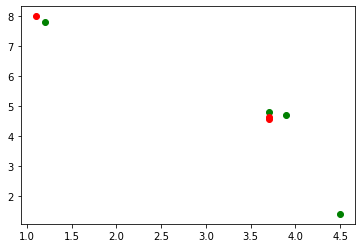

In [10]:
import matplotlib.pyplot as plt

_ = plt.scatter(gtruth[:,0], gtruth[:,1], c='g')
_ = plt.scatter(predicted[:,0], predicted[:,1], c='r')
plt.show()